In [34]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt
import GPy

import os

import matplotlib as mpl
import matplotlib.tri as tri

import ternary
import pickle
import datetime

from collections import Counter
import matplotlib.ticker as ticker
import random

import pyDOE
import random
from scipy.stats import norm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [35]:
cd /Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/P3HT

/Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/P3HT


In [36]:
dataset = pd.read_csv(r'/Users/liangqiaohao/Downloads/PV Lab/2020/March/Learning project/P3HT/P3HT_dataset.csv')
X = dataset.iloc[:,5:10]
# i put negative sign here because default BO is for minimization
X['Conductivity'] = -dataset.iloc[:,13].values

X_run = X.groupby(['P3HT content (%)', 'D1 content (%)','D2 content (%)','D6 content (%)','D8 content (%)'])['Conductivity'].agg(lambda x: x.unique().mean())
X_run = (X_run.to_frame()).reset_index()
X_run

,P3HT content (%),D1 content (%),D2 content (%),D6 content (%),D8 content (%),Conductivity
0,15.00,0.00,0.00,85.00,0.00,-45.970
1,16.15,0.46,25.38,51.42,6.55,-16.905
2,16.88,1.25,24.96,49.58,7.32,-20.030
3,17.71,0.98,25.34,50.30,5.68,-14.780
4,18.67,0.27,47.09,24.03,9.99,-14.080
...,...,...,...,...,...,...
173,93.87,0.24,0.56,0.24,5.11,-9.020
174,94.58,0.03,1.15,1.38,2.91,-9.710
175,94.81,0.30,0.28,0.08,4.53,-6.440
176,95.00,0.00,0.00,0.00,5.00,-26.190


In [37]:
features = ['P3HT content (%)', 'D1 content (%)','D2 content (%)','D6 content (%)','D8 content (%)']
X_feature = X_run[['P3HT content (%)', 'D1 content (%)','D2 content (%)','D6 content (%)','D8 content (%)']].values

y = np.array(X_run['Conductivity'].values)

raw_mean = np.mean(y)
raw_std = np.std(y)

In [38]:
y = (y - raw_mean) / raw_std

In [39]:
seed_list = [5, 892, 91, 2345, 391, 77, 223, 8258, 16, 3, 84,7646,6207,4530,8206,6260,2342,3112,5187,2737,8979,4018,8223,1678,9481,2232,
             461,7694,6091, 3189,2480,9106,1316,8500,2531,5329,9872,1388,8805,2726,119,3416,7747,3927,138,1488,232,4564,3492,9841]

In [44]:
def calc_():
    list_n_est = list(np.arange(3, 100))
    mean_train_score = []
    std_train_score = []
    mean_test_score = []
    std_test_score = []
    param_grid = {'n_estimators': list_n_est}
    
    for s in seed_list[:25]:
        print('initializing seed = ' +str(seed_list.index(s)))
        rf = RandomForestRegressor()   
        X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.20, random_state=1)
        
        grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 0, return_train_score = True)
        grid_search.fit(X_train, y_train)
        
#         print(grid_search.cv_results_)
        
        mean_train_score.append(grid_search.cv_results_['mean_train_score'])
        std_train_score.append(grid_search.cv_results_['std_train_score'])
        mean_test_score.append(grid_search.cv_results_['mean_test_score'])
        std_test_score.append(grid_search.cv_results_['std_test_score'])
        
        
        print('Finished seed')
    return list_n_est, mean_train_score, std_train_score, mean_test_score, std_test_score
        

In [45]:
list_n_est, mean_train_score, std_train_score, mean_test_score, std_test_score = calc_()

initializing seed = 0
Finished seed
initializing seed = 1
Finished seed
initializing seed = 2
Finished seed
initializing seed = 3
Finished seed
initializing seed = 4
Finished seed
initializing seed = 5
Finished seed
initializing seed = 6
Finished seed
initializing seed = 7
Finished seed
initializing seed = 8
Finished seed
initializing seed = 9
Finished seed
initializing seed = 10
Finished seed
initializing seed = 11
Finished seed
initializing seed = 12
Finished seed
initializing seed = 13
Finished seed
initializing seed = 14
Finished seed
initializing seed = 15
Finished seed
initializing seed = 16
Finished seed
initializing seed = 17
Finished seed
initializing seed = 18
Finished seed
initializing seed = 19
Finished seed
initializing seed = 20
Finished seed
initializing seed = 21
Finished seed
initializing seed = 22
Finished seed
initializing seed = 23
Finished seed
initializing seed = 24
Finished seed


In [10]:
def aggregation_(seed, n_runs, n_fold):
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
    random.seed(seed)
    
    index_runs = list(np.arange(n_runs))
    
    agg_list = []
    
    i = 0
    
    while i < n_fold:
    
        index_i = random.sample(index_runs, fold_size)
        for j in index_i:
            index_runs.remove(j)
            
        agg_list.append(index_i)
        
        i += 1
        
    return agg_list



def avg_(x):
#     nsteps
    n_eval = len(list_n_est) 
    
#     fold
    n_fold = 5
    
#     rows = # of ensembles = 25
    n_runs = len(x)
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
#     # of seeds 
    seed_list = [5, 892, 91, 2345, 391, 77, 223, 8258, 16, 3]
    n_sets = len(seed_list)
    
    l_index_list = []
    
    for i in np.arange(n_sets):
        
        s = aggregation_(seed_list[i], n_runs, n_fold)
        l_index_list.extend(s)

#     rows in l_index_list

    assert len(l_index_list) == n_sets * n_fold
    

    
    l_avg_runs = []

    for i in np.arange(len(l_index_list)):
        
        avg_run = np.zeros(n_eval)
        for j in l_index_list[i]:
            
            avg_run += np.array(x[j])
            
        avg_run = avg_run/fold_size
        l_avg_runs.append(avg_run)
    

    assert n_eval == len(l_avg_runs[0])
    
    return l_avg_runs 

def test_mean_(l_avg_runs):
    
    n_eval = len(l_avg_runs[0])
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    

    
    for i in np.arange(n_eval):
        i_column = []
        for j in np.arange(len(l_avg_runs)):
            i_column.append(l_avg_runs[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        low_q[i] = np.quantile(i_column, 0.25, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.75, out=None, overwrite_input=False, interpolation='linear')
        
        
    return np.array(median_), np.array(low_q), np.array(high_q), np.array(mean_)




In [47]:
aaa = test_mean_(avg_(mean_test_score))
bbb = test_mean_(avg_(std_test_score))
ccc = test_mean_(avg_(mean_train_score))
ddd = test_mean_(avg_(std_train_score))

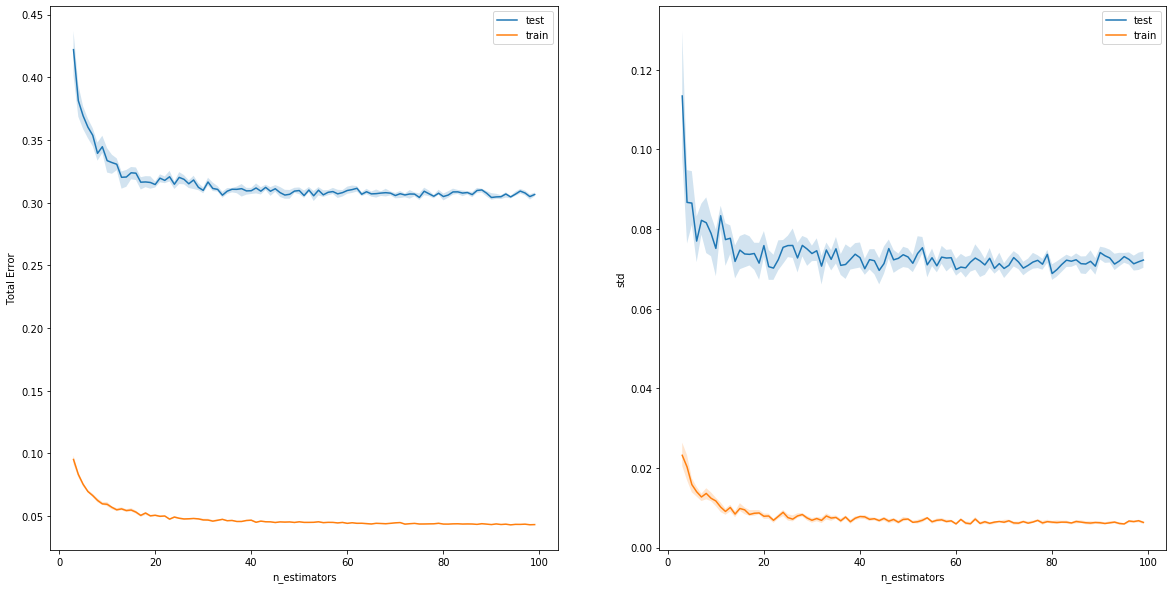

In [53]:
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

ax0.plot(list_n_est, 1 - aaa[0], label = 'test')
ax0.fill_between(list_n_est, 1 - aaa[1], 1 - aaa[2], alpha=0.2)
ax0.plot(list_n_est, 1 - ccc[0], label = 'train')
ax0.fill_between(list_n_est, 1 - ccc[1], 1 - ccc[2], alpha=0.2)
ax0.legend()
# ax0.set_xscale('log')
ax0.set_ylabel('Total Error')
ax0.set_xlabel('n_estimators')

ax1.plot(list_n_est, bbb[0], label = 'test')
ax1.fill_between(list_n_est, bbb[1], bbb[2], alpha=0.2)
ax1.plot(list_n_est, ddd[0], label = 'train')
ax1.fill_between(list_n_est, ddd[1], ddd[2], alpha=0.2)

ax1.set_ylabel('std')
ax1.set_xlabel('n_estimators')
ax1.legend()
